In [1]:
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import os
import random
import numpy as np

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

from tensorflow.keras.optimizers import RMSprop

In [2]:
import tensorflow as tf
print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2.10.0
Num GPUs Available:  1


In [3]:
# Preprocessing Data before training
training_dir = "MaskNoMaskDS\\training\\"

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.2,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    training_dir,
    batch_size=100,
    class_mode='categorical',
    target_size=(150,150)
)

validation_dir = "MaskNoMaskDS\\testing\\"

validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    batch_size=100,
    class_mode='categorical',
    target_size=(150,150)
)

Found 1304 images belonging to 2 classes.
Found 146 images belonging to 2 classes.


In [4]:
# Loading MobileNet model without its default classification head

pre_trained_model = MobileNetV2(
    input_shape=(150,150,3),
    include_top=False,
    weights='imagenet'
)

In [5]:
# Freezing all the layers so that they dont get updated while training

for layer in pre_trained_model.layers:
    layer.trainable = False

In [6]:
pre_trained_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 75, 75, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 75, 75, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 75, 75, 32)   0           ['bn_Conv1[0][

 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 19, 19, 144)  576        ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_depthwise_relu (ReLU)  (None, 19, 19, 144)  0           ['block_3_depthwise_BN[0][0]']   
                                                                                                  
 block_3_project (Conv2D)       (None, 19, 19, 32)   4608        ['block_3_depthwise_relu[0][0]'] 
                                                                                                  
 block_3_project_BN (BatchNorma  (None, 19, 19, 32)  128         ['block_3_project[0][0]']        
 lization)

 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 10, 10, 384)  0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 10, 10, 384)  3456       ['block_7_expand_relu[0][0]']    
 nv2D)                                                                                            
                                                                                                  
 block_7_depthwise_BN (BatchNor  (None, 10, 10, 384)  1536       ['block_7_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_7_d

 block_10_project_BN (BatchNorm  (None, 10, 10, 96)  384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 10, 10, 576)  55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_expand_BN (BatchNorma  (None, 10, 10, 576)  2304       ['block_11_expand[0][0]']        
 lization)                                                                                        
                                                                                                  
 block_11_expand_relu (ReLU)    (None, 10, 10, 576)  0           ['block_11_expand_BN[0][0]']     
                                                                                                  
 block_11_

                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 5, 5, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 5, 5, 160)    153600      ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_project_BN (BatchNorm  (None, 5, 5, 160)   640         ['block_14_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_14_add (Add)             (None, 5, 5, 160)    0           ['block_13_project_BN[0][0]',    
                                                                  'block_14_project_BN[0][0]']    
          

In [7]:
last_layer = pre_trained_model.get_layer('block_14_add')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 5, 5, 160)


In [8]:
# Attaching custom build classification head with two 
# classes to the existing MobileNet Model

x = layers.Flatten()(last_output)
x = layers.Dense(1024,activation='relu')(x)
x = layers.Dense(512,activation='relu')(x)
output_layer = layers.Dense(2,activation='softmax')(x)

input_layer = pre_trained_model.input

model = Model(input_layer,output_layer)

In [9]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 75, 75, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 75, 75, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 75, 75, 32)   0           ['bn_Conv1[0][0]']           

 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 19, 19, 144)  576        ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_depthwise_relu (ReLU)  (None, 19, 19, 144)  0           ['block_3_depthwise_BN[0][0]']   
                                                                                                  
 block_3_project (Conv2D)       (None, 19, 19, 32)   4608        ['block_3_depthwise_relu[0][0]'] 
                                                                                                  
 block_3_project_BN (BatchNorma  (None, 19, 19, 32)  128         ['block_3_project[0][0]']        
 lization)

 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 10, 10, 384)  0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 10, 10, 384)  3456       ['block_7_expand_relu[0][0]']    
 nv2D)                                                                                            
                                                                                                  
 block_7_depthwise_BN (BatchNor  (None, 10, 10, 384)  1536       ['block_7_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_7_d

 block_10_project_BN (BatchNorm  (None, 10, 10, 96)  384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 10, 10, 576)  55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_expand_BN (BatchNorma  (None, 10, 10, 576)  2304       ['block_11_expand[0][0]']        
 lization)                                                                                        
                                                                                                  
 block_11_expand_relu (ReLU)    (None, 10, 10, 576)  0           ['block_11_expand_BN[0][0]']     
                                                                                                  
 block_11_

                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 5, 5, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 5, 5, 160)    153600      ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_project_BN (BatchNorm  (None, 5, 5, 160)   640         ['block_14_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_14_add (Add)             (None, 5, 5, 160)    0           ['block_13_project_BN[0][0]',    
                                                                  'block_14_project_BN[0][0]']    
          

In [10]:
from tensorflow.keras.callbacks import LearningRateScheduler
import math

initial_learning_rate = 0.01

def lr_exp_decay(epoch, lr):
    k = 0.1
    return initial_learning_rate * math.exp(-k*epoch)

model.compile(
    optimizer=RMSprop(learning_rate=initial_learning_rate),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=50,
    callbacks=[LearningRateScheduler(lr_exp_decay,verbose=1)],
)


Epoch 1: LearningRateScheduler setting learning rate to 0.01.
Epoch 1/50
14/14 [==============================] - 17s 515ms/step - loss: 2153.4094 - accuracy: 0.7454 - val_loss: 1.4829 - val_accuracy: 0.9589 - lr: 0.0100

Epoch 2: LearningRateScheduler setting learning rate to 0.009048374180359595.
Epoch 2/50
14/14 [==============================] - 6s 432ms/step - loss: 0.6253 - accuracy: 0.9624 - val_loss: 0.1002 - val_accuracy: 0.9726 - lr: 0.0090

Epoch 3: LearningRateScheduler setting learning rate to 0.008187307530779819.
Epoch 3/50
14/14 [==============================] - 6s 446ms/step - loss: 6.4359 - accuracy: 0.9126 - val_loss: 0.5999 - val_accuracy: 0.9658 - lr: 0.0082

Epoch 4: LearningRateScheduler setting learning rate to 0.007408182206817179.
Epoch 4/50
14/14 [==============================] - 6s 435ms/step - loss: 0.7064 - accuracy: 0.9279 - val_loss: 0.2271 - val_accuracy: 0.9726 - lr: 0.0074

Epoch 5: LearningRateScheduler setting learning rate to 0.00670320046035639

14/14 [==============================] - 7s 495ms/step - loss: 0.0056 - accuracy: 0.9985 - val_loss: 0.0028 - val_accuracy: 1.0000 - lr: 3.3373e-04

Epoch 36: LearningRateScheduler setting learning rate to 0.00030197383422318503.
Epoch 36/50
14/14 [==============================] - 6s 445ms/step - loss: 0.0060 - accuracy: 0.9977 - val_loss: 0.0109 - val_accuracy: 0.9932 - lr: 3.0197e-04

Epoch 37: LearningRateScheduler setting learning rate to 0.0002732372244729256.
Epoch 37/50
14/14 [==============================] - 6s 465ms/step - loss: 0.0037 - accuracy: 0.9992 - val_loss: 0.0146 - val_accuracy: 0.9932 - lr: 2.7324e-04

Epoch 38: LearningRateScheduler setting learning rate to 0.00024723526470339386.
Epoch 38/50
14/14 [==============================] - 6s 430ms/step - loss: 0.0105 - accuracy: 0.9977 - val_loss: 0.0057 - val_accuracy: 1.0000 - lr: 2.4724e-04

Epoch 39: LearningRateScheduler setting learning rate to 0.00022370771856165591.
Epoch 39/50
14/14 [==========================

In [11]:
# Saving the trained model
model.save('h5_weigth\\mnm_model.h5')

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


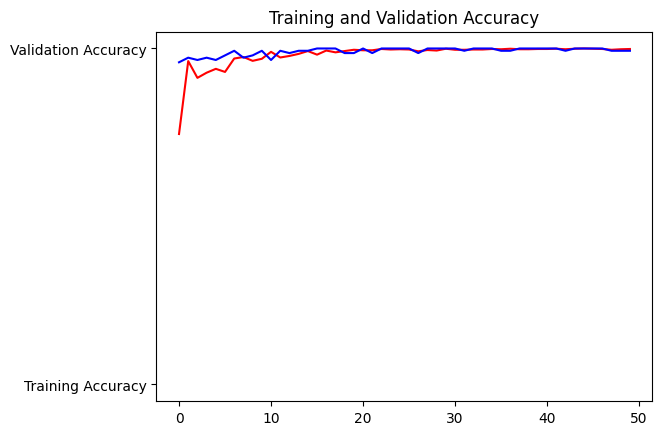

<Figure size 640x480 with 0 Axes>

In [12]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
print(history.history.keys())
# acc = history.keys
fig = plt.figure()
accuracy = history.history['accuracy']
val_accuracy= history.history['val_accuracy']

epochs=range(len(accuracy)) 

plt.plot(epochs,accuracy,'r','Training Accuracy')
plt.plot(epochs,val_accuracy,'b','Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.figure()
fig.savefig('Accuracy.png')

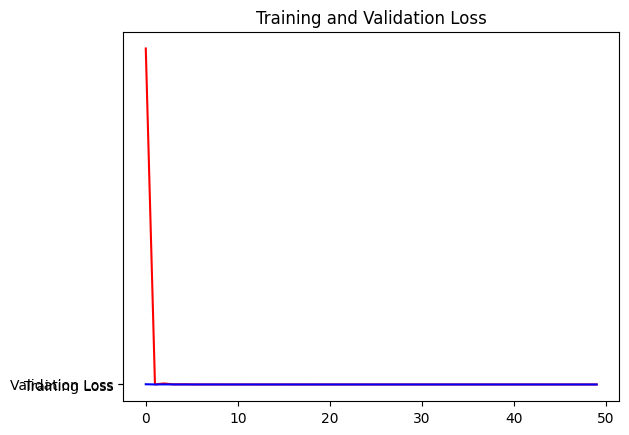

<Figure size 640x480 with 0 Axes>

In [13]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

fig = plt.figure()
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs=range(len(accuracy))

plt.plot(epochs,loss,'r','Training Loss')
plt.plot(epochs,val_loss,'b','Validation Loss')
plt.title('Training and Validation Loss')
plt.figure()
fig.savefig('Loss.png')